In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score as get_r2_score, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


In [ ]:
downloaded = drive.CreateFile({'id':'15X31Q-RYIUfEKXkTeszOOfkICqQf8Zj4'}) 
downloaded.GetContentFile('ChicagoCrimeCountMonthly.csv')  
data = pd.read_csv('ChicagoCrimeCountMonthly.csv', error_bad_lines=False)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data["Date"] = data["Date"].dt.strftime("%m/%d/%Y")
data.columns = ['Date', 'Crime Count']

In [ ]:
data

,Date,Crime Count
0,01/31/2001,74995
1,02/28/2001,66288
2,03/31/2001,53122
3,04/30/2001,40166
4,05/31/2001,41876
...,...,...
188,09/30/2016,23235
189,10/31/2016,23314
190,11/30/2016,21140
191,12/31/2016,19580


In [ ]:
crime_counts = np.asarray(data['Crime Count'].values)
print(len(crime_counts))
dates = np.asarray(data['Date'].values)
print(len(dates))

193
193


In [ ]:
def measure_error(actual, predicted):
  rmse = np.sqrt(mean_squared_error(actual, predicted))
  r2 = get_r2_score(actual, predicted)
  return rmse, r2 

In [ ]:
def fit_model(X, y, n_steps, n_features):
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
  # model.add(Dense(50, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  print(model.summary())
  print(len(X), len(y))
  model.fit(X, y, epochs=1000, verbose=0)

  return model

In [ ]:
def split_sequence(crime_counts, dates, n_steps):
  X, y, X_dates, y_date = list(), list(), list(), list()
  for i in range(len(crime_counts)):
    end_ix = i + n_steps
    if end_ix > len(crime_counts)-1:
      break
    seq_x, seq_y = crime_counts[i : end_ix], crime_counts[end_ix]
    seq_x_dates, seq_y_date = dates[i : end_ix], dates[end_ix]
    X.append(seq_x)
    y.append(seq_y)
    X_dates.append(seq_x_dates)
    y_date.append(seq_y_date)
  return np.array(X), np.array(y), np.array(X_dates), np.array(y_date)

In [ ]:
def split_train_test_data(X, y, train_size, test_size):
  return X[0: train_size], X[train_size: train_size + test_size], y[0: train_size], y[train_size: train_size + test_size] 

In [ ]:
def evaluation_on__rolling_forecasting(crime_counts, dates, train_size, test_size):
  
  # defines how many time we want to insert into model to predict next timing
  n_steps = 40
  # split into samples
  X, y, X_dates, y_date = split_sequence(crime_counts, dates, n_steps)
  record_size = len(X)

  # reshape from [samples, timesteps] into [samples, timesteps, features]
  n_features = 1
  # print(X.shape[0], X.shape[1])
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  X_dates = X_dates.reshape((X_dates.shape[0], X_dates.shape[1], n_features))
  rmse_scores = []
  r2_scores = []
  predictions = []
  y_test = []
  y_test_date = []
  model = None
  print("train_size", train_size, "test_size", test_size, "record_size", record_size)
  for i in range(train_size, record_size - test_size):
    y_test = []
    y_test_date = []
    X_train, X_test, y_train, y_test= split_train_test_data(X , y, i, test_size)
    X_train_dates, X_test_dates, y_train_date, y_test_date = split_train_test_data(X_dates , y_date, i, test_size)

    model = fit_model(X_train, y_train, n_steps, n_features)
    print("Done Training The Data")

    predictions = []
    for i in range(0, len(X_test)):
      x_input = np.array(X_test[i])
      x_input = x_input.reshape((1, n_steps, n_features))
      yhat = model.predict(x_input, verbose=0)
      # print('Date', y_test_date[i])
      # print("Time Series Values", X_test[i])
      print("Predicted Crime Count", yhat[0][0], "Real Crime Count", y_test[i])
      predictions.append(yhat[0][0])
    print("Done Predicting The Data")
    rmse, r2 = measure_error(y_test, predictions)
    print(' RMSE: %.3f \t R2 score: %.3f' % (rmse, r2))
    rmse_scores.append(rmse)
    r2_scores.append(r2)
  return rmse_scores, r2_scores, model, predictions, y_test, y_test_date

In [ ]:
def summarize(rmse_scores, r2_scores):
    rmse_scores = [i for i in rmse_scores]
    r2_scores = [i for i in r2_scores]
    rmse_mean, rmse_std = np.mean(rmse_scores), np.std(rmse_scores)
    r2_mean, r2_std = np.mean(r2_scores), np.std(r2_scores)
    print('RMSE: %.3f (+/- %.3f)' % (rmse_mean, rmse_std))
    print('R2: %.3f (+/- %.3f)' % (r2_mean, r2_std))
    plt.boxplot(rmse_scores)
    plt.show()
    plt.boxplot(r2_scores)
    plt.show()

In [ ]:
train_size=138
test_size = 12
rmse_scores, r2_scores, model, predictions, y_test, y_test_date = evaluation_on__rolling_forecasting(crime_counts, dates, train_size, test_size)

train_size 138 test_size 12 record_size 153
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_47 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 51        
Total params: 13,001
Trainable params: 13,001
Non-trainable params: 0
_________________________________________________________________
None
138 138
Done Training The Data
Predicted Crime Count 13062.691 Real Crime Count 20486
Predicted Crime Count 7657.9644 Real Crime Count 21006
Predicted Crime Count 9276.726 Real Crime Count 20375
Predicted Crime Count 22947.145 Real Crime Count 18590
Predicted Crime Count 13349.09 Real Crime Count 21878
Predicted Crime Count 2654

In [ ]:
model.save('RNN_Univariant_Monthly.h5')

In [ ]:
y_test_date = pd.to_datetime(y_test)
y_test_date = y_test_date.dt.year

DatetimeIndex(['1970-01-01 00:00:00.000020375',
               '1970-01-01 00:00:00.000018590',
               '1970-01-01 00:00:00.000021878',
               '1970-01-01 00:00:00.000020962',
               '1970-01-01 00:00:00.000023332',
               '1970-01-01 00:00:00.000023791',
               '1970-01-01 00:00:00.000024646',
               '1970-01-01 00:00:00.000024619',
               '1970-01-01 00:00:00.000023235',
               '1970-01-01 00:00:00.000023314',
               '1970-01-01 00:00:00.000021140',
               '1970-01-01 00:00:00.000019580'],
              dtype='datetime64[ns]', freq=None)

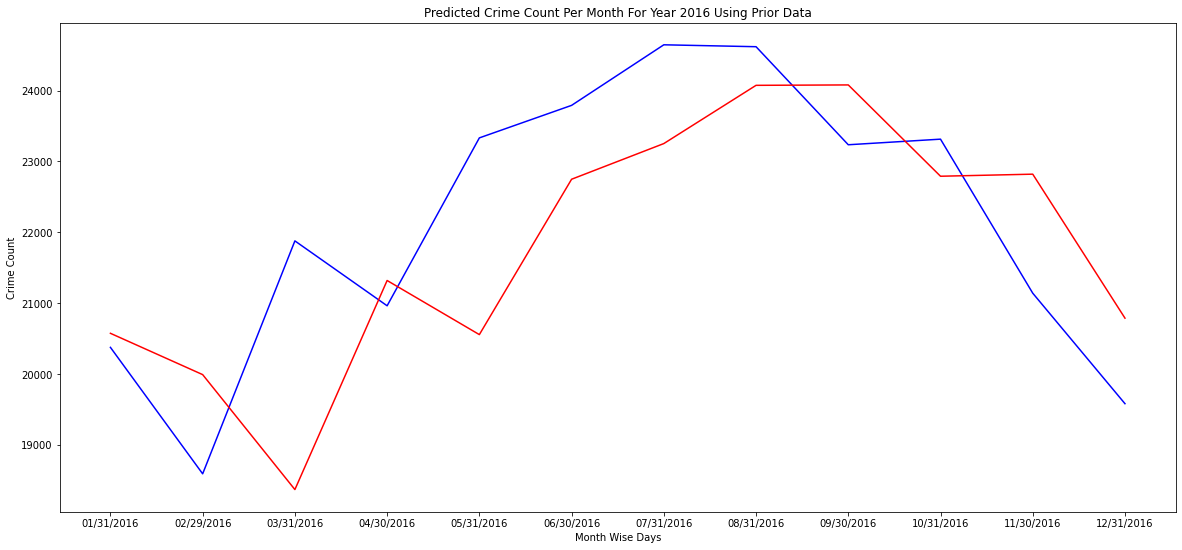

In [ ]:
plt.figure(figsize=(20, 9))
plt.title('Predicted Crime Count Per Month For Year 2016 Using Prior Data')
plt.plot(y_test_date, y_test, color = 'blue')
plt.plot(y_test_date, predictions, color= 'red')
plt.ylabel('Crime Count')
plt.xlabel('Month Wise Days')
plt.show()

In [ ]:
def mean_absolute_percentage_error(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

RMSE: 1600.921 (+/- 0.000)
R2: 0.299 (+/- 0.000)


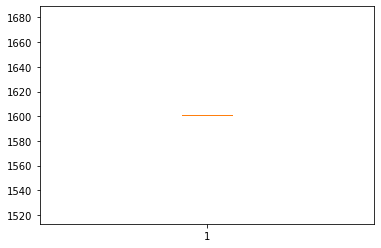

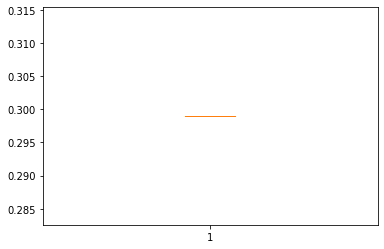

In [ ]:
summarize(rmse_scores, r2_scores)